#Node Classification in Graph Neural Network 
## Experimenting with continual learning

**Name**: *Alessandro Quattrociocchi*

**Matricola**: *1609286*

In [ ]:
! pip install spektral -qqq

     |████████████████████████████████| 123 kB 24.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from spektral.layers import GCNConv
from numpy.core.numeric import True_
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from spektral.datasets.citation import Citation
from spektral.transforms import LayerPreprocess
from spektral.transforms import AdjToSpTensor, GCNFilter
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import BatchNormalization, Dropout, Input

tf.random.set_seed(1234)
np.random.seed(1234)


# Dataset Presetation

The CiteSeer is one the datasets available from the Spektral library and consists of 3327 scientific publications classified into one of six classes. The citation network consists of 4732 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 3703 unique words.

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    """
    :param X: input tensor (non sparse)
    :return: sparse tensor
    """
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

A graph convolutional networks remains valid if we replace the adjacency matrix 
with another matrix having the same sparsity and which does not change the graph's tolopology. For this reason, we can consider some transofrmations to have better training properties on the training as:

- Adding self loops A = A + I 
- Adjacency matrix normalization $A= D^{-1/2} A D^{-1/2}$
According to this two properties i preprocess the dataset using applying GCN transformation.

In [ ]:
#downloading the graph 
dataset = Citation('citeseer', normalize=True, transforms=[LayerPreprocess(GCNConv)])
#extract the single graph from the dataset
graph = dataset[0]
#extract node-features matrix, adjacency matrix, labels
x, a, y = graph.x, convert_sparse_matrix_to_sparse_tensor(graph.a), graph.y
#extract train, validation and test masks 
mask_tr, mask_va, mask_te = dataset.mask_tr, dataset.mask_va, dataset.mask_te
masks = [mask_tr, mask_va, mask_te]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
print("Number of nodes: ", graph.n_nodes)
print("Number of labels:", graph.n_labels)

Number of nodes:  3327
Number of labels: 6


Below is the number of elements for each class, although for this first part it is not particularly useful, this plot will help a lot to understand how to balance the second splitting of the model. 

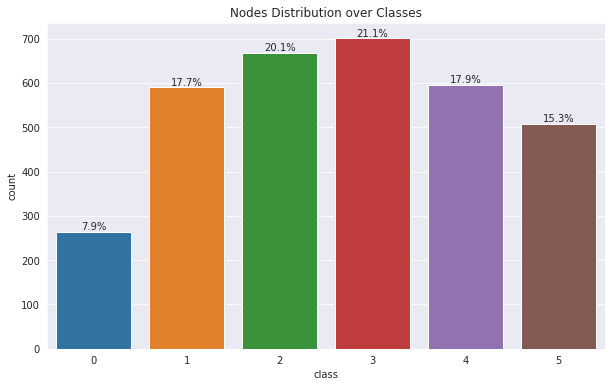

In [ ]:
sns.set_style("darkgrid")
classes = np.argmax(y, axis=1)
unique, counts = np.unique(classes, return_counts=True)
classes_dict = dict(zip(unique, counts))

df = pd.DataFrame({"item" : classes, 
                  "labels" : len(classes) })

ncount = len(df)

plt.figure(figsize=(10,6))
ax = sns.countplot(x="item", data=df)
plt.title('Nodes Distribution over Classes')
plt.xlabel('class')

for p in ax.patches:
    x_df=p.get_bbox().get_points()[:,0]
    y_df=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y_df/ncount), (x_df.mean(), y_df), 
            ha='center', va='bottom')

# GCN: Graph Convolutional Network 

Let's report some informations about GCN layer: 
The graph convolutional layer is defined as: $[H]_{i} = \phi \Big(\sum_{j \in N_{i}}A_{i,j}W^Tx_j\Big)$.  
CGN Layer can be interpreted as following: 
- A local node-wise operation $\hat{x_j} = W^Tx_{j}$
- An aggregation with respect to the neighbourhood $\rightarrow$ Message Passing
- Standard non linearity

## Model Definition

In [ ]:
class Net(Model):

    """
    Definition of the model, structured as following: 
      
      - 1 GCN of dimension (node_features, hidden_units)
      - 1 Dropout Layer with probability of 0.5
      - 1 GCN of dimension (hidden_units, classes)
    """

    def __init__(self,hidden_units=16,dropout=0.5):
        super().__init__()

        self.conv1 = GCNConv(hidden_units, activation="relu",use_bias=True_)
        self.drop1 = Dropout(0.5)
        self.conv2 = GCNConv(6, activation="softmax",use_bias=True)

    def call(self,inputs):
      x, a = inputs
      x = self.conv1([x,a]) 
      x = self.drop1(x)
      x = self.conv2([x,a])
      return x

## Building The Custom Training Loop of the Model

In [ ]:
class Train:
  """
  The Train class takes care of the 
  training and evaluation of the model 
  """

  def __init__(self, loss_fn ,optimizer):
    """
    :param loss_fn: loss funtion 
    :param optimizer: model optimizer
    """
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    super().__init__()


  @tf.function
  def train(self, model, inputs, y, mask):
    """
    :param model: input model 
    :param inputs: [x,a] list of node features matrix and adj matrix
    :param y: hot encoding vector of labels  
    :param mask: graph masking binary matrix according to the dataset split
    :return: void function
    """
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = self.loss_fn(y[mask], predictions[mask])
    gradients = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  @tf.function
  def evaluate(self, model, inputs, y, mask):
    """
    :param model: input model 
    :param inputs: [x,a] list of node features matrix and adj matrix
    :param y: hot encoding vector of labels  
    :param mask: graph masking binary matrix according to the dataset split
    :return: loss, accuracy (float, float)
    """
    predictions = model(inputs, training=False)
    loss = self.loss_fn(y[mask], predictions[mask])
    acc = tf.reduce_mean(categorical_accuracy(y[mask], predictions[mask]))
    return loss, acc

  def fit(self, model, x, a, y, masks, epochs=400, patience=100):
      """
      :param model: input model 
      :param x: node features matrix
      :param a: adj matrix (sparse tensor)
      :param y: hot encoding vector of labels  
      :param masks: list of binary masks
      """
      tr_mask, va_mask, te_mask = masks
      tr_loss, va_loss, te_loss = [],[],[]
      tr_acc, va_acc, te_acc = [],[],[]
      accuracies, losses = {}, {}
      best_val_loss = 99999
      best_test_acc = 0
      current_patience = patience 

      for epoch in range(1, epochs+1):

        self.train(model, [x,a], y, mask_tr)

        tr_loss.append(self.evaluate(model, [x,a], y, tr_mask)[0].numpy())
        tr_acc.append(self.evaluate(model, [x,a], y, tr_mask)[1].numpy())

        va_loss.append(self.evaluate(model, [x,a], y, va_mask)[0].numpy())
        va_acc.append(self.evaluate(model,  [x,a], y, va_mask)[1].numpy()) 

        te_loss.append(self.evaluate(model, [x,a], y, te_mask)[0].numpy())
        te_acc.append(self.evaluate(model,  [x,a], y, te_mask)[1].numpy()) 


        #Early Stopping Monitoring 

        if va_loss[-1] < best_val_loss:
          best_val_loss = va_loss[-1]
          best_test_acc = te_acc[-1]
          current_patience = patience
          
          if (epoch % 10==0):
            print("Improved")
            print("Epoch: {:d}, "
                "Loss tr: {:.4f}, Acc tr: {:.4f}, "
                "Loss va: {:.4f}, Acc va: {:.4f}, "
                "Loss te: {:.4f}, Acc te: {:.4f}".format(int(epoch), tr_loss[-1], tr_acc[-1], va_loss[-1], va_acc[-1], te_loss[-1], te_acc[-1]))
        else:
            current_patience -= 1
            if current_patience == 0:
              print("Max patience reached ===> stopping training...")
              break

        
      losses['train_loss'] = tr_loss
      losses['val_loss']   = va_loss
      losses['test_loss']  = te_loss

      accuracies['train_acc'] = tr_acc
      accuracies['val_acc']  = va_acc
      accuracies['test_acc']  = te_acc

## Fitting the Model

In [ ]:
#initializing the model with number of hidden layer and dropout value
model = Net(hidden_units=16,dropout=0.5)
#setting the optimizer and learning rate
optimizer = Adam(learning_rate=0.001)
#selecting the Categorical Loss function
loss_fn = CategoricalCrossentropy()
#initializing the Train class with the loss function and the optimizer
train_model = Train(loss_fn ,optimizer)

In [ ]:
model.summary()

Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv (GCNConv)          multiple                  59264     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 gcn_conv_1 (GCNConv)        multiple                  102       
                                                                 
Total params: 59,366
Trainable params: 59,366
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model fitting
train_model.fit(model, x, a, y, masks, epochs= 300, patience = 20)

Improved
Epoch: 10, Loss tr: 1.5896, Acc tr: 0.6417, Loss va: 1.7182, Acc va: 0.3040, Loss te: 1.7234, Acc te: 0.2630
Improved
Epoch: 20, Loss tr: 1.3547, Acc tr: 0.7500, Loss va: 1.6412, Acc va: 0.3320, Loss te: 1.6492, Acc te: 0.3030
Improved
Epoch: 30, Loss tr: 1.1288, Acc tr: 0.7917, Loss va: 1.5666, Acc va: 0.3780, Loss te: 1.5759, Acc te: 0.3470
Improved
Epoch: 40, Loss tr: 0.9346, Acc tr: 0.8333, Loss va: 1.4980, Acc va: 0.4300, Loss te: 1.5091, Acc te: 0.3920
Improved
Epoch: 50, Loss tr: 0.7693, Acc tr: 0.9250, Loss va: 1.4345, Acc va: 0.4680, Loss te: 1.4483, Acc te: 0.4370
Improved
Epoch: 60, Loss tr: 0.6320, Acc tr: 0.9583, Loss va: 1.3769, Acc va: 0.5220, Loss te: 1.3926, Acc te: 0.4940
Improved
Epoch: 70, Loss tr: 0.5170, Acc tr: 0.9750, Loss va: 1.3270, Acc va: 0.5480, Loss te: 1.3451, Acc te: 0.5340
Improved
Epoch: 80, Loss tr: 0.4214, Acc tr: 0.9917, Loss va: 1.2790, Acc va: 0.5680, Loss te: 1.2991, Acc te: 0.5530
Improved
Epoch: 90, Loss tr: 0.3438, Acc tr: 1.0000, Los

# Part 2: EWC - Elastic Weights Consolidation 

## Multi Tasks Splitting of the Dataset

#### The idea behind the splitting
The dataset contains a very high number of testing examples and a very low number of training and validation examples. Since, as we have seen in the previous point, the training of the model is characterised by a high overfitting value, I have re-indexed the whole dataset in order to have more data for training. 
#### The idea behid the Multi-Head Model
In this case, since the graph is a connected structure that we cannot divide each node independently (as images) since they depend on the topology of the graph itself, i performed the multi-task by considering different masks for each of the tasks.  
Three masks, one per each tasks, are created: 
- Task A $\rightarrow$ classes $[0,3]$ 
- Task B $\rightarrow$ classes $[2,5]$ 
- Task A $\rightarrow$ classes $[1,4]$ 

This allowed me to train the model considering the whole graph as input but to minimise the loss function through GDA considering only the labels of each single task.

In [ ]:
class MultiTasksSplitting:
  def __init__(self, y, n_nodes, selection):
    super(MultiTasksSplitting,self).__init__()

    self.classes = np.argmax(y, axis=1)
    self.n_classes = 6 
    self.selection = selection
    self.n_nodes = n_nodes 

  def _get_classes_indexes(self,selection):    
    """
    :param selection: the selected task 
    :return: void function
    """
    if selection == "task_A":
      #selecting the class 0 and class 3 and bindign them together
      self.task = np.where(np.isin(self.classes, [0,3]))[0]
    elif selection == "task_B":
      #selecting the class 2 and class 5 and bindign them together
      self.task = np.where(np.isin(self.classes, [2,5]))[0]
    elif selection == "task_C":
      #selecting the class 2 and class 5 and bindign them together
      self.task = np.where(np.isin(self.classes, [1,4]))[0]

  def _get_split_idx(self, task_idx_array):
     
    """
    This function split data into train, validation and test arrays

    :param task_idx_array: array of the index divided per task
    :return: bool arrays of train, validation and test
    """
    shuffle(task_idx_array)
    n = len(task_idx_array)
    idx_tr = task_idx_array[0:int(n*0.7)]
    idx_va = task_idx_array[int(n*0.8):int(n*0.9)]
    idx_te = task_idx_array[int(n*0.9):]
    return idx_tr, idx_va, idx_te

  def task_to_mask(self):
    """
    This function masks the index genereted from _get_split_idx 
    by creating a boolean matrix. 
    :return: list of train, val and test task
    """
    self._get_classes_indexes(self.selection)
    idx_tr, idx_va, idx_te = self._get_split_idx(self.task)
    mask_tr = np.zeros(self.n_nodes, dtype=bool)
    mask_va = np.zeros(self.n_nodes, dtype=bool)
    mask_te = np.zeros(self.n_nodes, dtype=bool)
    mask_tr[idx_tr] = True
    mask_va[idx_va] = True
    mask_te[idx_te] = True
    masks = [mask_tr, mask_va, mask_te]
    return masks


## Splitting the dataset according to the tasks

In [ ]:
#extracting the number of nodes
N = dataset.n_nodes
#########################################
#splitting and masking task A 
split_tasks = MultiTasksSplitting(y, N, selection="task_A")
masks_task_A = split_tasks.task_to_mask()
#########################################
#splitting and masking task B
split_tasks = MultiTasksSplitting(y, N, selection="task_B")
masks_task_B = split_tasks.task_to_mask()
#########################################
#splitting and masking task C
split_tasks = MultiTasksSplitting(y, N, selection="task_C")
masks_task_C = split_tasks.task_to_mask()

## How to extract informations from the trained task: The Fisher Information Matrix

In [ ]:
def get_fisher_matrix(model, x, a, y, mask):
  """
  This function computes the fisher matrix 
  :param model: input model 
  :param x: node-features matrix
  :param a: adjacency matrix
  :param y: one hot encoder of the label class
  :params mask: binary mask of the weights
  :return: fisher matrix
  """
  fisher_matrix = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}
  for idx,node in (enumerate(tqdm(mask))):
    if node:
      with tf.GradientTape() as tape:
        #compute the prediction of the model
        predictions = model([x,a])
        #compute the loss function with respect to the labels
        loss = loss_fn(y[idx], predictions[idx])
      #compute the gradients
      gradients = tape.gradient(loss, model.weights)

      for idx, weight in enumerate(gradients):
        #square of the gradient
        fisher_matrix[idx] += gradients[idx]**2 
  for idx, weight in enumerate(gradients):
    #normalizing the fisher matrix with respect to the training examples
    fisher_matrix[idx] /= sum(mask)
  return fisher_matrix

### Task Incremental Approach: Regularization Method to Overcome Catastrofic Forgetting

In [ ]:
class Elastic_Weights_Consolidation():
  """
  This class implements the Elastic Weights Consolidation,
  a technique used in continual learning to overcome the catastrophic forgetting 
  in streaming application.
  """
  def __init__(self, loss_fn ,optimizer):
    """
    :param loss_fn: loss function 
    :param optimizer: optimizer of the training phase
    """
    super().__init__()
    self.loss_fn = loss_fn
    self.optimizer = optimizer

  def compute_penalty_loss(self, fisher_matrix, weights, prior_weights,lambda_):
    """
    This function compute the penalty loss introduced 
    to keep track of the past tasks that the model has learned.

    :param loss_fn: loss function 
    :param optimizer: optimizer of the training phase
    """
    penalty = 0.
    for u, v, w in zip(fisher_matrix, weights, prior_weights):
        penalty += tf.math.reduce_sum(u * tf.math.square(v - w))
    return 0.5 * lambda_ * penalty
  
  @staticmethod
  def weights_deep_copy(model):
    """
    Creating a deep capy of the weights
    :param model: input model
    :return: list of the weights
    """
    old_thetas = []
    thetas = model.get_weights()
    for ii in range(len(thetas)):
      old_thetas.append(thetas[ii])
    return old_thetas

  def train_ewc(self, model, mask, fisher_matrix=None, prior_weights=None, lambda_=15):
    """
    :param model: input model 
    :param mask: binary train mask
    :param fisher_matrix: input matrix
    :param prior_weights: weights of the model trained over the previous task
    :param lambda: int, regularization parameter that weights the penalty loss
    """
    with tf.GradientTape() as tape:
      pred = model([x, a])
      loss = self.loss_fn(y[mask], pred[mask])
      #if the fisher matrix is provided, the penalty loss is then computed
      if fisher_matrix is not None:
        loss += self.compute_penalty_loss(fisher_matrix, model.trainable_variables, prior_weights, lambda_)
      gradients = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      return model

  @staticmethod
  def evaluate(x, a, y, model, masks_dict, epoch_num, verbose=True):
    """
    This function evaluates the model over all the masks: train, validation and test

    :param x: node-features matrix 
    :param a: adjacency matrix 
    :param y: one hot-encoder matrix
    :param model: input model
    :param masks_dict: mask dictionary that contains all the possible combinations of the masks
    :param epoch_num: (int) number of the epochs to train
    :param verbose: bool, if True print the statistics of the training
    """
    mask_tr_A = masks_dict['task_A'][0]
    mask_tr_B = masks_dict['task_B'][0]
    mask_tr_C = masks_dict['task_C'][0]

    mask_va_A = masks_dict['task_A'][1]
    mask_va_B = masks_dict['task_B'][1]
    mask_va_C = masks_dict['task_C'][1]

    mask_te_A = masks_dict['task_A'][2]
    mask_te_B = masks_dict['task_B'][2]
    mask_te_C = masks_dict['task_C'][2]

    pred = model([x,a]).numpy().argmax(axis=1)
    
    acc_tr_A = (pred[mask_tr_A] == y[mask_tr_A].argmax(axis=1)).mean()
    acc_tr_B = (pred[mask_tr_B] == y[mask_tr_B].argmax(axis=1)).mean()
    acc_tr_C = (pred[mask_tr_C] == y[mask_tr_C].argmax(axis=1)).mean()

    acc_va_A = (pred[mask_va_A] == y[mask_va_A].argmax(axis=1)).mean()
    acc_va_B = (pred[mask_va_B] == y[mask_va_B].argmax(axis=1)).mean()
    acc_va_C = (pred[mask_va_C] == y[mask_va_C].argmax(axis=1)).mean()

    acc_te_A = (pred[mask_te_A] == y[mask_te_A].argmax(axis=1)).mean()
    acc_te_B = (pred[mask_te_B] == y[mask_te_B].argmax(axis=1)).mean()
    acc_te_C = (pred[mask_te_C] == y[mask_te_C].argmax(axis=1)).mean()

    if verbose:
      print(
            "Acc tr A: {:.4f}, Acc va A: {:.4f}, "
            "Acc tr B: {:.4f}, Acc va B: {:.4f}, "
            "Acc tr C: {:.4f}, Acc va C: {:.4f}, ".format(acc_tr_A, acc_va_A, acc_tr_B, acc_tr_B, acc_tr_C, acc_va_C))

    return [acc_te_A, acc_te_B, acc_te_C]

# Defining Proper Metrics for EWC

In this part i want to define new metrics related to continuous learning. For the sake of clarity, we introduce global accuracy, a unique value of the overall accuracy value over all the tasks. 
Finally, the backward transfer, which indicates how much having trained the model on the new task has affected the performance of the model: negative values show a worsening of performance as training epochs increase. 

In [ ]:
class BackwardTransfer(tf.keras.metrics.Metric):
  """
  This function evaluates the model over all the masks: train, validation and test

  :param x: node-features matrix 
  :param a: adjacency matrix 
  :param y: one hot-encoder matrix
  :param model: input model
  :param masks_dict: mask dictionary that contains all the possible combinations of the masks
  :param epoch_num: (int) number of the epochs to train
  :param verbose: bool, if True print the statistics of the training
  """

  def __init__(self, epochs):
    self.epochs = epochs
    super(BackwardTransfer, self).__init__()


  def update_state(self, n_tasks, acc_te_A, acc_te_B, acc_te_C= None):
    """
    This function evaluates the model over all the masks: train, validation and test

    :param n_task: numbers of task to be solved
    :param acc_te_A: list of accuracues of task A 
    :param acc_te_B: list of accuracues of task A
    :param acc_te_C: list of accuracues of task A
    """

    self.global_acc = 0 
    self.bkw_transfer = 0 

    if n_tasks == 2: 
      acc_te_task_A_11 = acc_te_A[self.epochs-1]
      acc_te_task_A_21 = acc_te_A[2*self.epochs-1]
      acc_te_task_B_22 = acc_te_B[2*self.epochs-1]
      self.global_acc = (acc_te_task_A_11 + acc_te_task_A_21 + acc_te_task_B_22)/(0.5*n_tasks*(n_tasks+1))
      self.bkw_transfer = (acc_te_task_A_21 - acc_te_task_A_11)/(0.5*n_tasks*(n_tasks-1))

    elif n_tasks == 3: 
      acc_te_task_A_11 = acc_te_A[self.epochs-1]
      acc_te_task_A_21 = acc_te_A[2*self.epochs-1]
      acc_te_task_A_31 = acc_te_A[3*self.epochs-1]

      acc_te_task_B_22 = acc_te_B[2*self.epochs-1]
      acc_te_task_B_32 = acc_te_B[3*self.epochs-1]


      self.global_acc = (acc_te_task_A_11 + acc_te_task_A_21 + acc_te_task_A_31 + acc_te_task_B_22 + acc_te_task_B_32)/(0.5*n_tasks*(n_tasks+1))
      self.bkw_transfer = ((acc_te_task_A_21 - acc_te_task_A_11)+(acc_te_task_B_32 - acc_te_task_B_22))/(0.5*n_tasks*(n_tasks-1))


  def result(self):
    """
    :return tuple(global_acc, backward_transfer): ewc metrics
    """
    return self.global_acc,self.bkw_transfer 

In [ ]:
#creating a dictionary with the overall tasks splitting 
tasks_dict = {'task_A':masks_task_A,
              'task_B': masks_task_B,
              'task_C': masks_task_C}

In [ ]:
#setting the epochs
epochs = 90 
#initializing the Elastic weights consolidation class
ewc = Elastic_Weights_Consolidation(loss_fn,optimizer)
#initializing the ewc metrics
ewc_metrics = BackwardTransfer(epochs)
#defining the model
multihead_model = Net()

# Task A

In [ ]:
#initializing three different lists for the test accuracy of tasks A,B,C.
acc_te_task_A, acc_te_task_B, acc_te_task_C = [], [], []
#fitting the model
for epoch in range(0,epochs):
  model_A = ewc.train_ewc(multihead_model, masks_task_A[0],lambda_=0)
  #evaluates the model
  accuracies = ewc.evaluate(x, a, y, model_A,tasks_dict, epoch, verbose=False)
  #filling all the results
  acc_te_task_A.append(accuracies[0])
  acc_te_task_B.append(accuracies[1])
  acc_te_task_C.append(accuracies[2])
print("=========================== Sigle Evaluation")
print("Test Accuracy On Task A:",round(acc_te_task_A[-1],4))
print("Test Accuracy On Task B:",round(acc_te_task_B[-1],4))
print("Test Accuracy On Task C:",round(acc_te_task_C[-1],4))

=========================== Sigle Evaluation
Test Accuracy On Task A: 0.8454
Test Accuracy On Task B: 0.0
Test Accuracy On Task C: 0.0


In [ ]:
#storing the old thetas
old_thetas_A = ewc.weights_deep_copy(model_A)
#computing the fisher matrix
fisher_mat_A = get_fisher_matrix(model_A, x, a, y, masks_task_A[0])

100%|██████████| 3327/3327 [00:44<00:00, 74.37it/s]


# Task B 

In [ ]:
for epoch in range(0,epochs):
  model_B = ewc.train_ewc(model_A, masks_task_B[0],fisher_mat_A,old_thetas_A,lambda_=1.8)
  accuracies = ewc.evaluate(x, a, y, model_B,tasks_dict, epoch, verbose=False)

  acc_te_task_A.append(accuracies[0])
  acc_te_task_B.append(accuracies[1])
  acc_te_task_C.append(accuracies[2])

print("=========================== Single Evaluation")
print("Test Accuracy On Task A:",round(acc_te_task_A[-1],4))
print("Test Accuracy On Task B:",round(acc_te_task_B[-1],4))
print("Test Accuracy On Task C:",round(acc_te_task_C[-1],4))
print("=========================== Global Evaluation")
#printing the global ewc metrics
ewc_metrics.update_state(2, acc_te_task_A, acc_te_task_B)
print("Global Accuracy Task B: ", round(ewc_metrics.result().numpy()[0],4))
print("Backward Transfer Task B: ", round(ewc_metrics.result().numpy()[1],4))

=========================== Single Evaluation
Test Accuracy On Task A: 0.5464
Test Accuracy On Task B: 0.7627
Test Accuracy On Task C: 0.0
=========================== Global Evaluation
Global Accuracy Task B:  0.7182
Backward Transfer Task B:  -0.299


In [ ]:
old_thetas_B = ewc.weights_deep_copy(model_B)
fisher_mat_B = get_fisher_matrix(model_B, x, a, y, masks_task_B[0])

100%|██████████| 3327/3327 [00:55<00:00, 60.09it/s]


In [ ]:
fisher_mat_AB = {n: tf.zeros_like(p.value()) for n, p in enumerate(multihead_model.trainable_variables)}

for i in range(4):
  #summing the two different matrices
  fisher_mat_AB[i] = fisher_mat_A[i] + fisher_mat_B[i]

# Task C

In [ ]:
for epoch in range(0,epochs):
  model_C = ewc.train_ewc(model_B, masks_task_C[0],fisher_mat_AB,old_thetas_B,lambda_=1.85)
  accuracies = ewc.evaluate(x, a, y, model_C,tasks_dict, epoch, verbose=False)

  acc_te_task_A.append(accuracies[0])
  acc_te_task_B.append(accuracies[1])
  acc_te_task_C.append(accuracies[2])
print("=========================== Single Evaluation")
print("Test Accuracy On Task A:",round(acc_te_task_A[-1],4))
print("Test Accuracy On Task B:",round(acc_te_task_B[-1],4))
print("Test Accuracy On Task C:",round(acc_te_task_C[-1],4))
print("=========================== Global Evaluation")
ewc_metrics.update_state(3, acc_te_task_A, acc_te_task_B, acc_te_task_C)
print("Global Accuracy Task C: ", round(ewc_metrics.result().numpy()[0],4))
print("Backward Transfer Task C: ", round(ewc_metrics.result().numpy()[1],4))


=========================== Single Evaluation
Test Accuracy On Task A: 0.5361
Test Accuracy On Task B: 0.6271
Test Accuracy On Task C: 0.8235
=========================== Global Evaluation
Global Accuracy Task C:  0.5529
Backward Transfer Task C:  -0.1449


# Final Plot 

This final plot shows the fraction of correct examples on the test set; the numerical values are reported directly on the plot. 
The main figure consists of 3 sub-plots: 
- The first one shows the changes of test accuracy of task A as we train task B and C. 
- The second shows the trend of task B as we train task C.
- The third shows the trend of task C while training. 

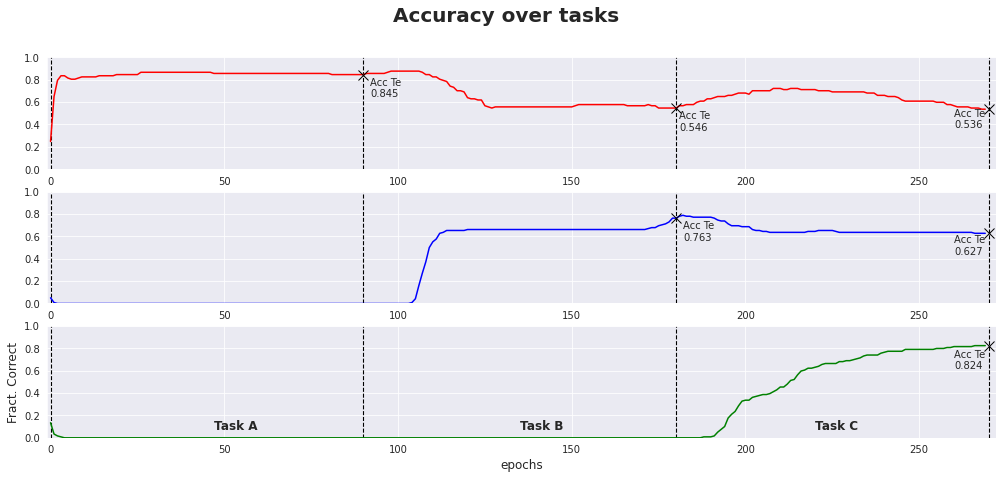

In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(17, 7))
gs = GridSpec(nrows=3, ncols=1)

#First Plot
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylim(0, 1)
ax0.set_xlim(-1, 3*epochs+2)
plt.vlines(x=[0, epochs, 2*epochs, 3*epochs], ymin=0, ymax=1, colors='black', ls='--', lw=1.1)
ax0.plot(acc_te_task_A, color='red')

ax0.plot(epochs,acc_te_task_A[epochs],'x', color='black', markersize=10) 
ax0.plot(2*epochs,acc_te_task_A[(2*epochs)-1],'x', color='black', markersize=10) 
ax0.plot(3*epochs,acc_te_task_A[3*epochs-1],'x', color='black', markersize=10) 
ax0.annotate('Acc Te \n'+ str(round(acc_te_task_A[epochs],3)),xy=(epochs+2,acc_te_task_A[epochs]-0.2))
ax0.annotate('Acc Te \n'+ str(round(acc_te_task_A[2*epochs],3)),xy=(2*epochs+1,acc_te_task_A[2*epochs-1]-0.2))
ax0.annotate('Acc Te \n'+ str(round(acc_te_task_A[(3*epochs)-1],3)),xy=((3*epochs)-10,acc_te_task_A[(3*epochs)-10]-0.2))

#Second Plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylim(0, 1)
ax1.set_xlim(-1, 3*epochs+2)
ax1.vlines(x=[0, epochs, 2*epochs, 3*epochs], ymin=0, ymax=1, colors='black', ls='--', lw=1.1)

ax1.plot(acc_te_task_B, color='blue')
ax1.plot(2*epochs,acc_te_task_B[(2*epochs)-1],'x', color='black', markersize=10)
ax1.plot(3*epochs,acc_te_task_B[3*epochs-1],'x', color='black', markersize=10)
ax1.annotate('Acc Te \n'+ str(round(acc_te_task_B[2*epochs],3)),xy=((2*epochs)+2,acc_te_task_B[2*epochs]-0.2))
ax1.annotate('Acc Te \n'+ str(round(acc_te_task_B[(3*epochs-1)],3)),xy=(3*epochs-10,acc_te_task_B[3*epochs-10]-0.2))

#Third Plot
ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylim(0, 1)
ax2.set_xlim(-1, 3*epochs+2)
ax2.vlines(x=[0, epochs, 2*epochs, 3*epochs], ymin=0, ymax=1, colors='black', ls='--', lw=1.1)

ax2.plot(acc_te_task_C,color='green')
ax2.plot(3*epochs,acc_te_task_C[(3*epochs)-1],'x', color='black', markersize=10)
ax2.annotate('Acc Te \n'+ str(round(acc_te_task_C[(3*epochs-1)],3)),xy=((3*epochs)-10,acc_te_task_C[(3*epochs)-10]-0.2))
plt.annotate('Task A', xy =(int(epochs/1.9), 0.07), fontweight="bold", fontsize=12)
plt.annotate('Task B', xy =(int((3/2)*epochs), 0.07), fontweight="bold", fontsize=12)
ax2.annotate('Task C', xy =(int(2.45*epochs), 0.07), fontweight="bold", fontsize=12)

fig.suptitle('Accuracy over tasks',fontweight="bold", size=20)
plt.ylabel("Fract. Correct", size=12)
plt.xlabel("epochs", size=12)

plt.show()

# References

- [Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)
- [SEMI-SUPERVISED CLASSIFICATION WITH
GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf)
- [ stijani /
elastic-weight-consolidation-tf2
](https://github.com/stijani/elastic-weight-consolidation-tf2)
- https://andrewliao11.github.io/blog/fisher-info-matrix/